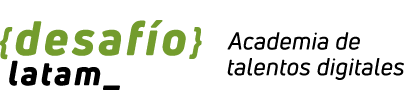

#<center><font color = 'green'>Solución Desafío - Detección de cardiopatías</font></center>

1. Carga los datos de los tres archivos unidos en un DataFrame, y prepáralos considerando las siguientes etapas:

   a. asigna a la variable objetivo num  un cero cuando su valor es cero, y un 1 en otro caso. Muestra la cantidad de valores ausente por atributo.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

feature_names = pd.read_csv('feature_names.csv', header=None).iloc[:,0].to_list()
df_cleveland = pd.read_csv('processed.cleveland.data', header=None)
df_hungarian = pd.read_csv('processed.hungarian.data', header=None)
df_switzerland = pd.read_csv('processed.switzerland.data', header=None)
df2 = pd.concat([df_cleveland, df_hungarian, df_switzerland], axis=0)
df2.columns = feature_names

print(df2.shape)
print()

# se codifica la variable objetivo con 0 y 1
df2['num'] = np.where(df2['num']==0, 0, 1)

# Se marcan los valores ausentes
df2 = df2.apply(lambda x: x.replace('?', np.nan))

condiciones = [
    (df2['restecg'] == 2.0) | (df2['restecg'] == '2'),
    (df2['restecg'] == 1.0) | (df2['restecg'] == '1'),
    (df2['restecg'] == 0.0) | (df2['restecg'] == '0')
]
df2['restecg'] = np.select(condiciones, [2, 1, 0], default=0)

df2.isnull().sum()
df2.head()



,age,sex,cp,threstbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,70.0,1.0,4.0,115,0,0,1,92,1,0,2,?,7,1
119,70.0,1.0,4.0,140,0,1,0,157,1,2,2,?,7,3
120,72.0,1.0,3.0,160,0,?,2,114,0,1.6,2,2,?,0
121,73.0,0.0,3.0,160,0,0,1,121,0,0,1,?,3,1


Procésalos considerando los siguientes criterios:

   i.  si el atributo presenta un porcentaje de valores ausentes mayor a 25%, entonces descartamos ese atributo.
   ii. para los atributos con valores ausentes menores al 25% se deben rellenar con el valor promedio del atributo de acuerdo a la clase, es decir, los valores ausentes para los cuales num=0 se deben rellenar con el promedio de los valores presentes para los cuales num=0.
   iii. para las variables categóricas, los valores a asignar (promedio) deben ser aproximados al valor entero más cercano.

   b. Construye variables dummies para las variables discretas con tres o más categorías.


In [ ]:
# Características con porcentaje de
# valores ausentes mayores a umbral
umbral = .25

arr_na = df2.isnull().sum().values / df2.shape[0]
columns_with_na = list(df2.columns[np.argwhere(np.logical_and(arr_na > 0, arr_na <= umbral)).ravel()])

del_columns = list(df2.columns[np.argwhere(arr_na > umbral).ravel()])
print(f'Columnas a descartar: {del_columns}')

df2 = df2.drop(columns=del_columns)

# Definir variables dummies
df2 = pd.get_dummies(df2, columns=['cp', 'restecg'], drop_first=True, dtype='int')
df2.head()

df2


Columnas a descartar: ['slope', 'ca', 'thal']


,age,sex,threstbps,chol,fbs,thalach,exang,oldpeak,num,cp_2.0,cp_3.0,cp_4.0,restecg_1,restecg_2
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0,0,0,0,0,1
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,1,0,0,1,0,1
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,1,0,0,1,0,1
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0,0,1,0,0,0
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,70.0,1.0,115,0,0,92,1,0,1,0,0,1,1,0
119,70.0,1.0,140,0,1,157,1,2,1,0,0,1,0,0
120,72.0,1.0,160,0,NaN,114,0,1.6,0,0,1,0,0,1
121,73.0,0.0,160,0,0,121,0,0,1,0,1,0,1,0


In [ ]:
# se imputa por promedio de acuerdo a la variable objetivo con o sin enfermedad
# redondeado al entero más cercano


cont_features = ['age', 'threstbps', 'chol', 'thalach', 'oldpeak']
disc_features = list(set(df2.columns) - set(cont_features))

for col_na in columns_with_na:
    prom_ = dict(df2.loc[:,['num', col_na]].dropna().astype('float').groupby(['num'])[col_na].mean())
    idx_rows0 = np.where((df2[col_na].isna()) & (df2['num']==0.0))[0]
    idx_rows1 = np.where((df2[col_na].isna()) & (df2['num']==1.0))[0]
    idx_col = np.where(df2.columns == col_na)[0]

    # Verificar si hay filas para actualizar antes de realizar la asignación
    if len(idx_rows0) > 0:
        df2.iloc[idx_rows0, idx_col] = np.round(prom_[0.0])
    if len(idx_rows1) > 0:
        df2.iloc[idx_rows1, idx_col] = np.round(prom_[1.0])

    if col_na in cont_features:
        df2[col_na] = df2[col_na].astype('float')
    else:
        df2[col_na] = df2[col_na].astype('int')

    print(col_na)




for col in list(set(df2.columns)-set(columns_with_na)):
    if col in cont_features:
        df2[col] = df2[col].astype('float')
    else:
        df2[col] = df2[col].astype('int')

threstbps
chol
fbs
thalach
exang
oldpeak


c. Realiza un análisis descriptivo por variable visualizando histogramas y gráficos de barra según corresponda. Construye una matriz de correlaciones con un heatmap, para las variables continuas. Plantea tus observaciones y conclusiones.

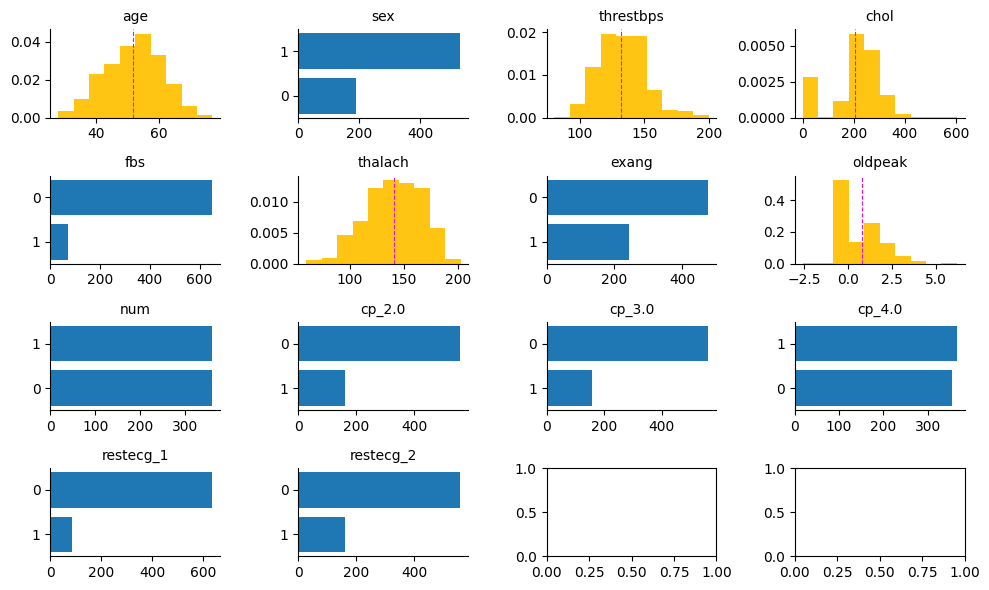

In [ ]:
def plot_descriptive(df, ncols=3, max_discrete=12, figsize=(13, 6),
                     plot_type='hist', target='', fontsize=10):
    '''
    plot_type: acepta valores in ['hist', 'boxplot']
    '''
    nrows = df.shape[1]//ncols
    if nrows*ncols < df.shape[1]:
        nrows += 1

    fig, ax = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols)

    i = 0
    for idx, (colname, serie)  in enumerate(df.items()):
        j = (idx % ncols)
        ax[i,j].set_title(colname, fontsize=fontsize)
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].spines['right'].set_visible(False)

        if (serie.dtype == 'object') or (
            serie.dtype == 'int64' and serie.unique().shape[0] <= max_discrete):
            serie = serie.value_counts().sort_values(ascending=True)

            ax_aux = ax[i,j].barh(
                y=np.array(serie.index).astype('str'),
                    width=serie.values,
            )
        else:
            if plot_type == 'hist':
                ax[i,j].hist(x=serie, color='xkcd:sunflower', density=True)
                ax[i,j].axvline(x=np.mean(serie), color='xkcd:fuchsia', ls='--', lw=0.8)
            elif plot_type == 'boxplot':
                ax[i,j].boxplot(serie)
                ax[i,j].set_xticklabels([''])

        if (j == ncols-1): i += 1

    plt.tight_layout()
    plt.show()

plot_descriptive(df2, figsize=(10, 6), ncols=4)

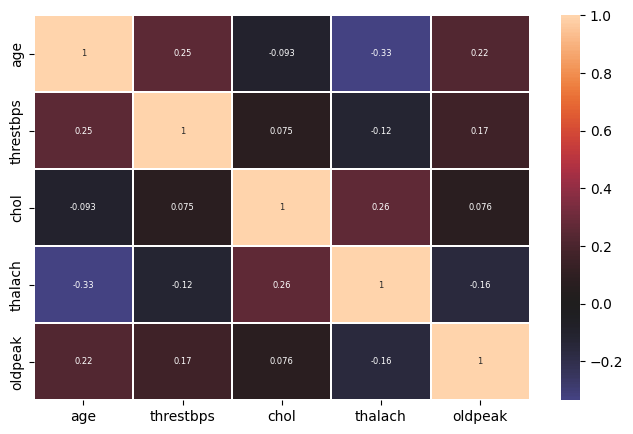

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(df2[cont_features].corr(), lw=0.05, linecolor='white', annot=True, annot_kws={'size': 6}, center=0.0, ax=ax)
plt.show();


2. Divide la muestra en entrenamiento y test (33%), y con ello:
  a.  entrena un modelo de ensamble secuencial AdaBoost
  b. entrena un modelo de ensamble secuencial Gradient Boosting
  c. entrena un modelo de ensamble secuencial XGBoosting

Para cada uno, utiliza hiper parámetros por defecto y muestra su desempeño usando las métricas adecuadas. Comenta.


In [ ]:
X = df2.drop(columns='num', axis=1)
y = df2['num']

X_train, X_test, y_train ,y_test = train_test_split(X, y, test_size=.33, random_state=23)


adboost_m1 = AdaBoostClassifier(random_state=23)
adboost_m1.fit(X_train, y_train)

yhat_adboost = adboost_m1.predict(X_test)
print(classification_report(y_test, yhat_adboost))


              precision    recall  f1-score   support

           0       0.82      0.82      0.82       126
           1       0.79      0.79      0.79       112

    accuracy                           0.81       238
   macro avg       0.81      0.81      0.81       238
weighted avg       0.81      0.81      0.81       238



In [ ]:
# Gradient Boosting
gboost_m1 = GradientBoostingClassifier(random_state=23)
gboost_m1.fit(X_train, y_train)

yhat_gboost = gboost_m1.predict(X_test)
print(classification_report(y_test, yhat_gboost))


              precision    recall  f1-score   support

           0       0.84      0.81      0.83       126
           1       0.79      0.83      0.81       112

    accuracy                           0.82       238
   macro avg       0.82      0.82      0.82       238
weighted avg       0.82      0.82      0.82       238



In [ ]:
# XGGradientBoosting
xgboost_m1 = xgb.XGBClassifier(random_state=23)
xgboost_m1.fit(X_train, y_train)

yhat_xgboost = xgboost_m1.predict(X_test)
print(classification_report(y_test, yhat_xgboost))


              precision    recall  f1-score   support

           0       0.85      0.79      0.81       126
           1       0.78      0.84      0.81       112

    accuracy                           0.81       238
   macro avg       0.81      0.81      0.81       238
weighted avg       0.81      0.81      0.81       238



3. Realiza una búsqueda del hiper parámetro para el modelo que resulte tener mejor desempeño (utiliza f1-score para determinarlo). Los valores a buscar para la grilla son:

  a. **n_estimators:** 20 a 200 con 15 valores

  b. **learning_rate:** 0.004 a 1.0 con 40 valores

  c. **sub_sample:** 0.1  a 1.0 con 18 valores

Muestra los mejores hiper parámetros encontrados y entrena un modelo con estos, presentando sus métricas.


In [ ]:
%%time

# mejor GradientBoosting
param_grid = {
    'n_estimators': np.linspace(100, 200, 10, dtype=int),
    'learning_rate': np.linspace(0.001, 1.0, 20),
    'subsample': np.linspace(0.3, 1.0, 10)
}

gboost_grid_m1 = GridSearchCV(GradientBoostingClassifier(random_state=23), param_grid= param_grid, cv=5, n_jobs=-1)
gboost_grid_m1.fit(X_train, y_train)


CPU times: user 25.7 s, sys: 2.92 s, total: 28.6 s
Wall time: 17min 58s


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=23),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.001     , 0.05357895, 0.10615789, 0.15873684, 0.21131579,
       0.26389474, 0.31647368, 0.36905263, 0.42163158, 0.47421053,
       0.52678947, 0.57936842, 0.63194737, 0.68452632, 0.73710526,
       0.78968421, 0.84226316, 0.89484211, 0.94742105, 1.        ]),
                         'n_estimators': array([100, 111, 122, 133, 144, 155, 166, 177, 188, 200]),
                         'subsample': array([0.3       , 0.37777778, 0.45555556, 0.53333333, 0.61111111,
       0.68888889, 0.76666667, 0.84444444, 0.92222222, 1.        ])})

In [ ]:
print(gboost_grid_m1.best_params_)

yhat_gboost = gboost_grid_m1.best_estimator_.predict(X_test)
print(classification_report(y_test, yhat_gboost))


{'learning_rate': 0.05357894736842105, 'n_estimators': 100, 'subsample': 0.45555555555555555}
              precision    recall  f1-score   support

           0       0.85      0.84      0.85       126
           1       0.82      0.84      0.83       112

    accuracy                           0.84       238
   macro avg       0.84      0.84      0.84       238
weighted avg       0.84      0.84      0.84       238



4. Elabora un gráfico con las curvas ROC para cada modelo entrenado, y a partir de ello recomienda alguno de ellos. Justifica la decisión

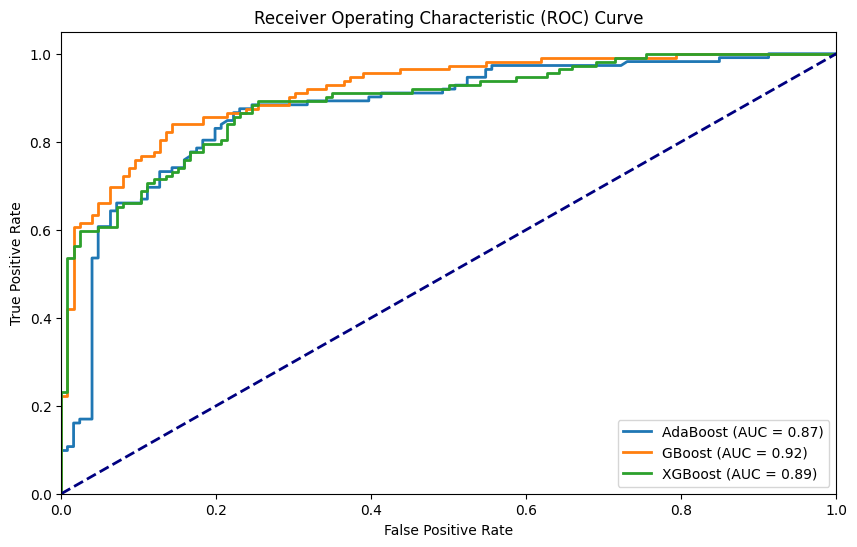

In [ ]:


def plot_roc(X_test, y_test, models, model_names):
    plt.figure(figsize=(10, 6))

    for model, name in zip(models, model_names):
        y_scores = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2, label='{} (AUC = {:.2f})'.format(name, roc_auc))

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()






plot_roc(X_test, y_test, [adboost_m1, gboost_grid_m1.best_estimator_, xgboost_m1], ['AdaBoost', 'GBoost', 'XGBoost'])

5. Muestra las variables por nivel de importancia para el mejor modelo, luego de la búsqueda de hiper parámetro. Comenta.

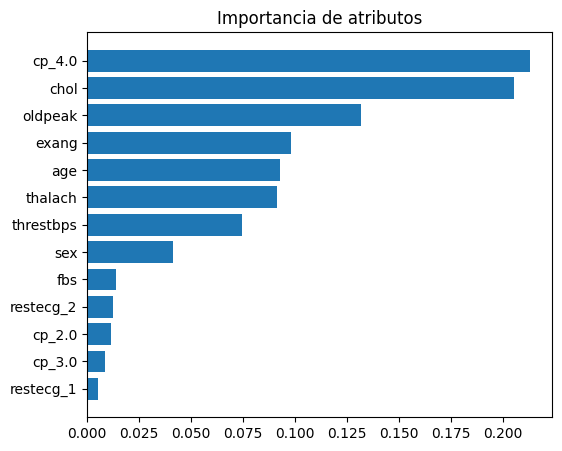

In [ ]:
df_im = pd.DataFrame({
    'feature': gboost_grid_m1.best_estimator_.feature_names_in_,
    'importance': gboost_grid_m1.best_estimator_.feature_importances_
}).sort_values(by='importance', ascending=True)

fig, ax = plt.subplots(figsize=(6, 5))
ax.barh(y=df_im['feature'], width=df_im['importance'])
ax.set_title('Importancia de atributos')
plt.show()
